# t-distributed Stochastic Neighbor Embedding (TSNE) Visualization

In this notebook we visualizes the TSNE of `RoBERTa-Sentinel` and `T5-Sentinel` on `open-gpt-text-split/test.jsonl`

## Initialization


In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from transformers import RobertaModel, RobertaTokenizer

from Model import SentinelNonLinear, T5Sentinel
from Dataset import OpenGPTDataset

In [2]:
PATH_ROOT = Path(Path.cwd().parent.parent.parent)
PATH_WEBTEXT = Path(PATH_ROOT, "data", "open-web-text-final")
PATH_GPTTEXT = Path(PATH_ROOT, "data", "open-gpt-text-final")

PATH_CACHE = Path(PATH_ROOT, "result", "cache")
PATH_T5_CHECKPT = Path(PATH_CACHE, "t5.small.0422.pt")
PATH_ROBERTA_CHECKPT = Path(PATH_CACHE, "roberta.base.0420.pt")

PATH_FIG = Path(PATH_ROOT, "result", "figures", "TSNE")
PATH_TXT = Path(PATH_ROOT, "result", "text")

In [3]:
print(f"Loading T5 Checkpoint {PATH_T5_CHECKPT}")
t5_checkpoint = torch.load(PATH_T5_CHECKPT, map_location="cpu")
print(f"with validation accuracy", t5_checkpoint["validAccuracy"])

print(f"Loading RoBERTa Checkpoint {PATH_ROBERTA_CHECKPT}")
roberta_checkpoint = torch.load(PATH_ROBERTA_CHECKPT, map_location="cpu")
print(f"with validation accuracy", roberta_checkpoint["validAccuracy"])

print("Loading dataset ...")
dataset = OpenGPTDataset(
    webTextPath=str(Path(PATH_WEBTEXT, "urlsf_subset04.jsonl")),
    gptTextPath=str(Path(PATH_GPTTEXT, "urlsf_subset04.jsonl"))
)

Loading T5 Checkpoint d:\Projects\GPT-Sentinel\result\cache\t5.small.0422.pt
with validation accuracy 0.9727494577006508
Loading RoBERTa Checkpoint d:\Projects\GPT-Sentinel\result\cache\roberta.base.0420.pt
with validation accuracy 0.935614224137931
Loading dataset ...


In [4]:
def tsne_analysis(hidden_states, output: str, title: str, perplexity=30):
    real_hidden = [hidden_states[key] for key in hidden_states if key.endswith("-web")]
    fake_hidden = [hidden_states[key] for key in hidden_states if key.endswith("-gpt")]
    real_Harray = np.concatenate(real_hidden, axis=0).reshape((len(real_hidden), -1))
    fake_Harray = np.concatenate(fake_hidden, axis=0).reshape((len(fake_hidden), -1))

    X_original = np.concatenate([real_Harray, fake_Harray], axis=0)
    
    pca_core = PCA(n_components=50)
    tsne_core = TSNE(n_components=2, perplexity=perplexity, verbose=1)

    pca_core.fit(X_original)
    X_pca = pca_core.transform(X_original)
    X_tsne = tsne_core.fit_transform(X_pca)

    real_tsne = X_tsne[:len(real_hidden)]
    fake_tsne = X_tsne[len(real_hidden):]

    plt.figure(dpi=200)
    plt.title(title)
    # if x_range is not None: plt.xlim(x_range)
    # if y_range is not None: plt.ylim(y_range)
    plt.scatter(real_tsne[:, 0], real_tsne[:, 1], label="OpenWebText" , s=1)
    plt.scatter(fake_tsne[:, 0], fake_tsne[:, 1], label="OpenGPTText" , s=1)
    plt.legend()
    plt.savefig(Path(PATH_FIG, output))
    return real_tsne, fake_tsne

def plot_tsne(real_tsne, fake_tsne):
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(real_tsne[:, 0], real_tsne[:, 1], label="OpenWebText" , s=1, color=(0.2, 0.647, 0.898, 0.5))
    ax.scatter(fake_tsne[:, 0], fake_tsne[:, 1], label="OpenGPTText" , s=1, color=(1, 0.6, 0.2, 0.5))
    return fig, ax

## TSNE Visualization on T5-Sentinel

In [5]:
model = T5Sentinel()
model.load_state_dict(t5_checkpoint["model"])
model = model.to("cuda")
model.eval()
print("Model Loaded")

Model Loaded


In [6]:
t5_cache = Path(PATH_CACHE, "t5_hidden.pt")

if t5_cache.exists():
    print("Cache Hit! Using existing cache")
    t5_preds, t5_hiddens = torch.load(t5_cache)
else:
    print("Cache Miss! Calculating hidden states...")
    t5_preds, t5_hiddens = dict(), dict()
    indices = range(len(dataset))
    for index in tqdm(indices):
        (text, label), (uid, _) = dataset[index]
        uid += "-web" if label == 0 else "-gpt"
        
        pred, hidden = model(text)
        hidden = hidden[-1] # We only take the last hidden layer
        pred, hidden = pred.detach().cpu().numpy(), hidden.detach().cpu().numpy()

        t5_preds[uid], t5_hiddens[uid] = pred, hidden

    torch.save([t5_preds, t5_hiddens], t5_cache)

Cache Hit! Using existing cache


In [7]:
t5_human_uids = [key for key in t5_hiddens.keys() if key.endswith("-web")]
t5_generate_uids = [key for key in t5_hiddens.keys() if key.endswith("-gpt")]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7368 samples in 0.000s...
[t-SNE] Computed neighbors for 7368 samples in 0.341s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7368
[t-SNE] Computed conditional probabilities for sample 2000 / 7368
[t-SNE] Computed conditional probabilities for sample 3000 / 7368
[t-SNE] Computed conditional probabilities for sample 4000 / 7368
[t-SNE] Computed conditional probabilities for sample 5000 / 7368
[t-SNE] Computed conditional probabilities for sample 6000 / 7368
[t-SNE] Computed conditional probabilities for sample 7000 / 7368
[t-SNE] Computed conditional probabilities for sample 7368 / 7368
[t-SNE] Mean sigma: 0.816384
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.325195
[t-SNE] KL divergence after 1000 iterations: 1.927020


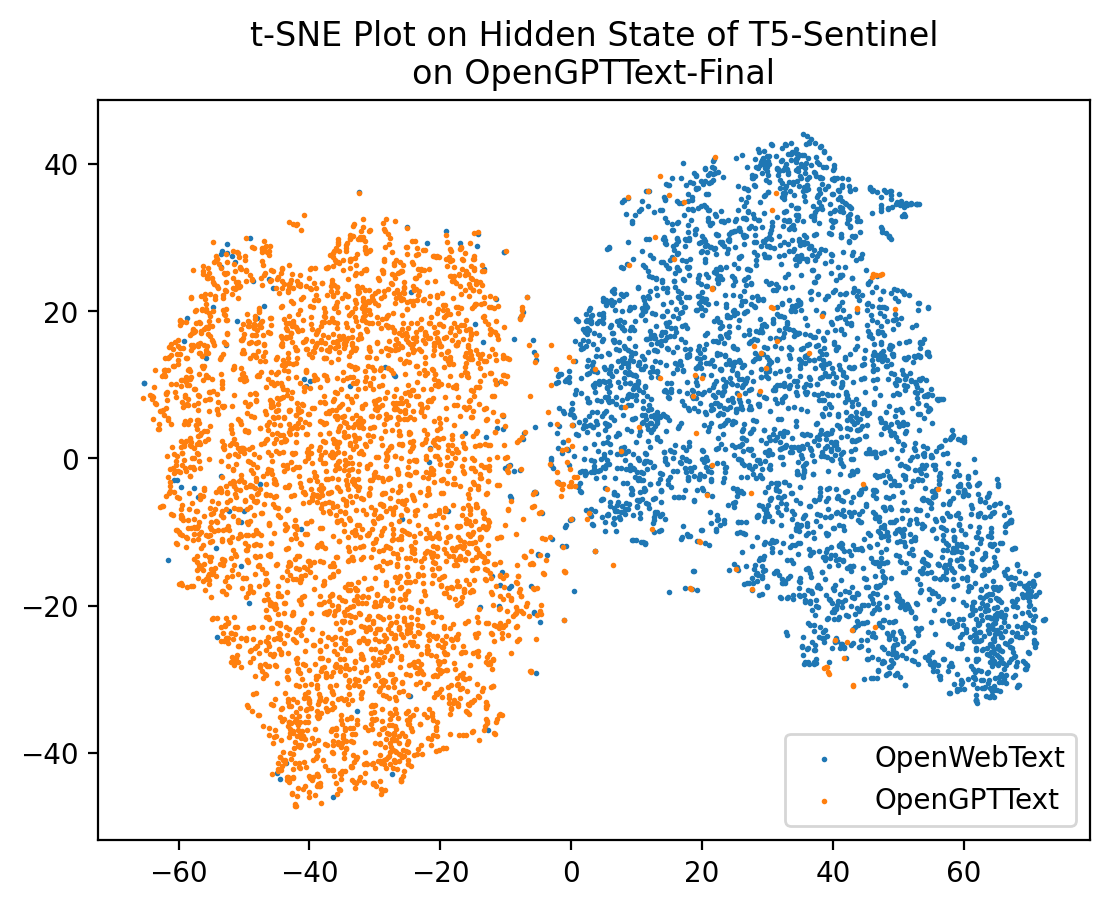

In [19]:
t5_real_tsne, t5_fake_tsne = tsne_analysis(
    t5_hiddens,
    output="tsne_t5-sentinel_OpenGPTText-Final.pdf",
    title="t-SNE Plot on Hidden State of T5-Sentinel\non OpenGPTText-Final",
    perplexity=50
)

1. Right-most Human Datapoint (most human-like human)

In [20]:
right_most_human_uid = t5_human_uids[np.argmax(t5_real_tsne[:, 0])]
right_most_human_tsne = t5_real_tsne[np.argmax(t5_real_tsne[:, 0])]
print("Right most human sample has UID:", right_most_human_uid)
print("Text sample:", dataset[right_most_human_uid[:-4]][0][0])

with open(Path(PATH_TXT, "tsne_sample1-text.md"), "w") as f:
    f.write("---\n")
    f.write("Desc: Outlier on the right, Sample 1, TSNE projection\n")
    f.write("UID: " + right_most_human_uid + "\n")
    f.write("---\n\n")
    f.write(dataset[right_most_human_uid[:-4]][0][0])

Right most human sample has UID: [urlsf_subset04]-[387629]-web
Text sample: Story highlights Priorities USA, a pro-Clinton outside group, is going after Texas Sen. Ted Cruz in their first candidate specific web ad
The ad casts Cruz as extreme and ends with text on the screen that argues the Texas senator is more "dangerous" than Republican front-runner Donald Trump
Manchester, New Hampshire (CNN) Priorities USA, a pro-Clinton outside group, is going after Texas Sen. Ted Cruz in their first candidate specific web ad.
The spot casts Cruz as extreme and ends with text on the screen that argues the presidential candidate is more "dangerous" than Republican front-runner Donald Trump.
"If you think Donald Trump is dangerous," reads the ad. "Watch out for Ted Cruz."
The ad, although only online for now, is a shift for the pro-Clinton group that raises money to benefit Clinton's candidacy. While the group has gone after Republicans in the past, this is the first time they have dedicated an ad 

2. Left-most GPT Datapoint (most GPT-like GPT)

In [21]:
left_most_gpt_uid = t5_generate_uids[np.argmin(t5_fake_tsne[:, 0])]
left_most_gpt_tsne = t5_fake_tsne[np.argmin(t5_fake_tsne[:, 0])]
print("Left most GPT sample has UID:", left_most_gpt_uid)
print("Text sample:", dataset[left_most_gpt_uid[:-4]][0][0])

with open(Path(PATH_TXT, "tsne_sample2-text.md"), "w") as f:
    f.write("---\n")
    f.write("Desc: Outlier on the top, Sample 2, TSNE projection\n")
    f.write("UID: " + left_most_gpt_uid + "\n")
    f.write("---\n\n")
    f.write(dataset[left_most_gpt_uid[:-4]][0][0])


Left most GPT sample has UID: [urlsf_subset04]-[312986]-gpt
Text sample: Correction appended.
Easter falls on Sunday, April 5, this year. If you don't already have plans for celebrating the holiday with the kids, here's a list of events we put together.
Easter egg hunts (don't forget to BYOB - bring your own basket)
Beaverton: Tualatin Hills Park & Recreation District will offer egg hunts at two of its recreation centers.
Cedar Hills Recreation Center is hosting two
Kids can splash in the pool and look for eggs from 6 to 8 p.m. Friday, April 3, at the
Garden Home Recreation Center will host a
Canby: The Sons of the American Legion will host an Easter Egg Hunt at 11 a.m. Saturday, April 4, at the Clackamas County Event Center, in the yellow parking lot.
Fairview:
Blue Lake Regional Park will be the setting for a
Fairview Community Park will host a free
Forest Grove:
The
The Forest Grove
The
Forest Grove Foursquare Church/His Church is hosting a free
Gaston: The Gaston Fire Department wi

3. Left most Human Text (most GPT-like Human)

In [22]:
left_most_human_uid = t5_human_uids[np.argmin(t5_real_tsne[:, 0])]
left_most_human_tsne = t5_real_tsne[np.argmin(t5_real_tsne[:, 0])]
print("Left most GPT sample has UID:", left_most_human_uid)
print("Text sample:", dataset[left_most_human_uid[:-4]][0][0])

with open(Path(PATH_TXT, "tsne_sample3-text.md"), "w") as f:
    f.write("---\n")
    f.write("Desc: Sample 3, TSNE projection\n")
    f.write("UID: " + left_most_human_uid + "\n")
    f.write("---\n\n")
    f.write(dataset[left_most_human_uid[:-4]][0][0])


Left most GPT sample has UID: [urlsf_subset04]-[327799]-web
Text sample: InstaWeather Pro makes it easy to not only share how good or bad the weather is but also lets you add a photo that will show off the conditions. The Windows Phone app normally runs $.99 but for through the myAppFree campaign, you can pick it up for free over the next twenty-four hours.
InstaWeather Pro isn't your typical Windows Phone weather app. The Windows Phone app lets you snap a photo, add an overlay of your current conditions and share the final image with your friends quickly and easily.
The concept with InstaWeather Pro is rather simple. You snap a photo at 1:1 aspect ratio (perfect for Instagram) and choose an overlay that reflects the weather conditions at your current location. Once saved, you can share the image over social networks such as Twitter, Facebook and Instagram or share it by SMS or email.
Overlays range from the basic temperature and location to more inspirational images. You also have the

4. Right most GPT text (most Human-like GPT)

In [23]:
right_most_gpt_uid = t5_generate_uids[np.argmax(t5_fake_tsne[:, 0])]
right_most_gpt_tsne = t5_fake_tsne[np.argmax(t5_fake_tsne[:, 0])]
print("Left most GPT sample has UID:", right_most_gpt_uid)
print("Text sample:", dataset[right_most_gpt_uid[:-4]][0][0])

with open(Path(PATH_TXT, "tsne_sample4-text.md"), "w") as f:
    f.write("---\n")
    f.write("Desc: Sample 4, TSNE projection\n")
    f.write("UID: " + right_most_gpt_uid + "\n")
    f.write("---\n\n")
    f.write(dataset[right_most_gpt_uid[:-4]][0][0])


Left most GPT sample has UID: [urlsf_subset04]-[36988]-gpt
Text sample: Nate@IND BimmerPost Supporting Vendor Rep 1812 Posts 11,237
Join Date: Oct 2006 Location: Chicago
19) iTrader: (
Drives: BMW
FluidMotorUnion "So We Made Some E9x Velocity Stacks.... "
Quote: FluidMotorUnion Originally Posted by
...And this came out.
Made entirely from 6061-grade aluminum, this new velocity stack set for the E9x M3 was conceived, designed, cut out and assembled in-house at Fluid MotorUnion. Our system incorporates an Aquamist water-methanol injection system, which runs from the tank in the back to a specially-designed manifold that splits up the 6mm inlet to eight 4mm direct-injection nozzles, which are placed at the ends of the arms that stretch over each individual stack. The tubing from the manifold to the nozzles, just like on the DCM3, are fed through specific channels in the arms themselves. When alls said and done, it looks like the grim reapers put his special touch on this system.
You may n

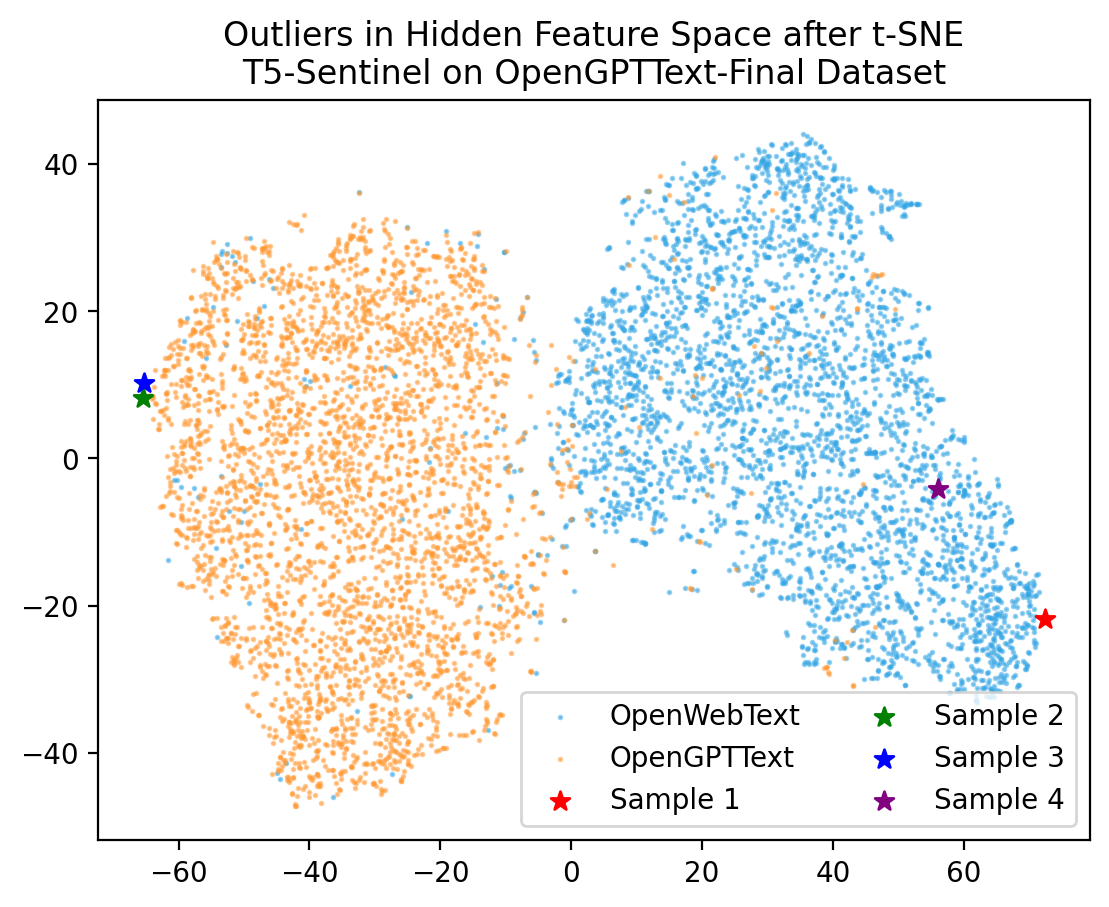

In [24]:
fig, ax = plot_tsne(t5_real_tsne, t5_fake_tsne)
ax.scatter(right_most_human_tsne[0], right_most_human_tsne[1], s=50, label="Sample 1", marker="*", c="red")
ax.scatter(left_most_gpt_tsne[0], left_most_gpt_tsne[1], s=50, label="Sample 2", marker="*", c="green")
ax.scatter(left_most_human_tsne[0], left_most_human_tsne[1], s=50, label="Sample 3", marker="*", c="blue")
ax.scatter(right_most_gpt_tsne[0], right_most_gpt_tsne[1], s=50, label="Sample 4", marker="*", c="purple")


ax.legend(ncol=2)
ax.set_title("Outliers in Hidden Feature Space after t-SNE\nT5-Sentinel on OpenGPTText-Final Dataset")
fig.savefig(Path(PATH_FIG, "tsne_sampling_outliers.pdf"))

## TSNE Visualization on RoBERTa-Sentinel

In [14]:
model = SentinelNonLinear(
    RobertaModel.from_pretrained("roberta-base"),
    RobertaTokenizer.from_pretrained("roberta-base"),
    ret_hidden=True
)
model.load_state_dict(roberta_checkpoint["model"])
model = model.to("cuda")
model.eval()
print("Model Loaded")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Loaded


In [15]:
roberta_cache_path = Path(PATH_CACHE, "clean_model_clean_data_hidden.pt")

if roberta_cache_path.exists():
    print("Cache Hit! Using existing cache")
    preds, hiddens = torch.load(roberta_cache_path)
else:
    print("Cache Miss! Calculating hidden states...")
    preds, hiddens = dict(), dict()
    for index in tqdm(range(len(dataset))):
        (text, label), (uid, _) = dataset[index]
        uid += "-web" if label == 0 else "-gpt"
        
        pred, hidden = dataset(text)
        pred, hidden = pred.detach().cpu().numpy(), hidden.detach().cpu().numpy()
        preds[uid] = pred
        hiddens[uid] = hidden
    torch.save([preds, hiddens], roberta_cache_path)

Cache Hit! Using existing cache


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7368 samples in 0.001s...
[t-SNE] Computed neighbors for 7368 samples in 0.346s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7368
[t-SNE] Computed conditional probabilities for sample 2000 / 7368
[t-SNE] Computed conditional probabilities for sample 3000 / 7368
[t-SNE] Computed conditional probabilities for sample 4000 / 7368
[t-SNE] Computed conditional probabilities for sample 5000 / 7368
[t-SNE] Computed conditional probabilities for sample 6000 / 7368
[t-SNE] Computed conditional probabilities for sample 7000 / 7368
[t-SNE] Computed conditional probabilities for sample 7368 / 7368
[t-SNE] Mean sigma: 0.164860
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.090805
[t-SNE] KL divergence after 1000 iterations: 1.632208


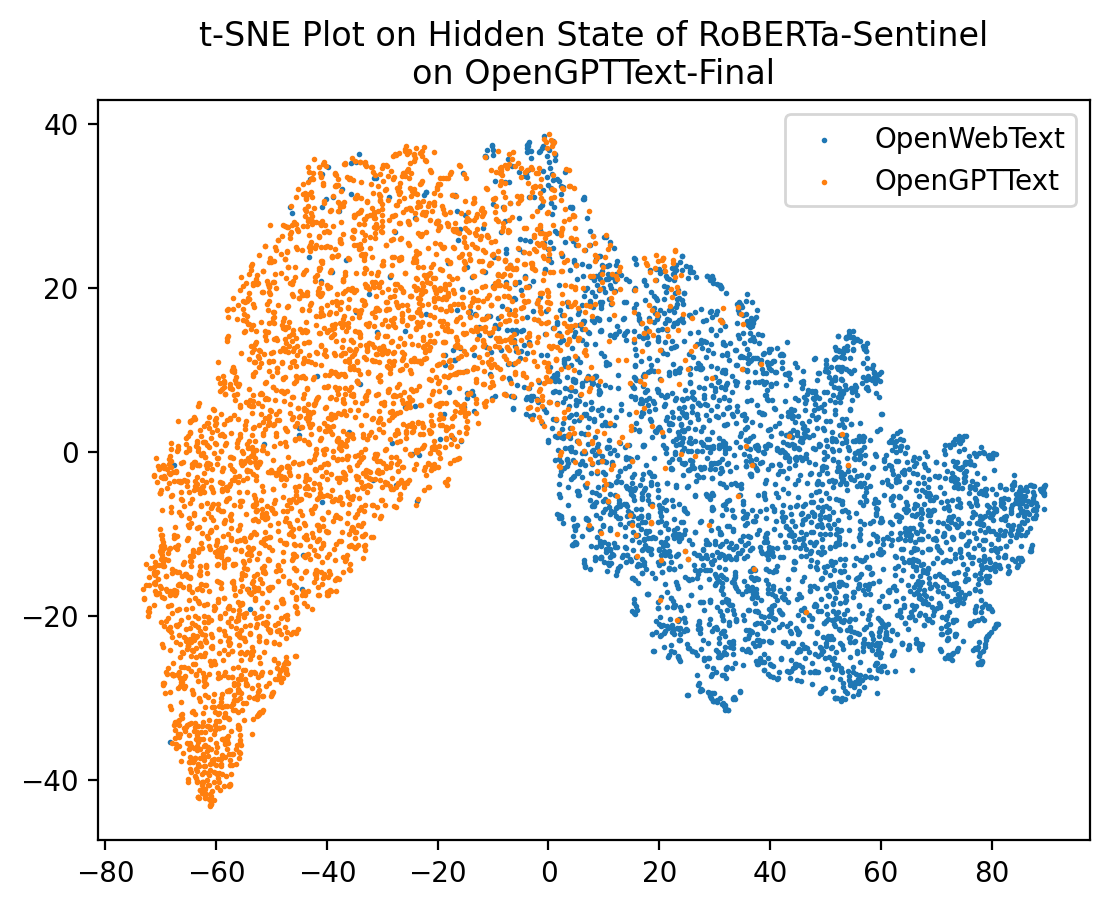

In [18]:
roberta_real_tsne, roberta_fake_tsne = tsne_analysis(
    hiddens,
    output="tsne_roberta-sentinel_OpenGPTText-Final.pdf",
    title="t-SNE Plot on Hidden State of RoBERTa-Sentinel\non OpenGPTText-Final",
    perplexity=50
)